###  MicroGrad demo

In [312]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

%matplotlib inline

In [313]:
np.random.seed(1337)
random.seed(1337)

In [314]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [315]:
# Загрузка данных MNIST
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
X_train = X_train.astype('float64') / 255.0 * 2 - 1
X_test = X_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# One-hot кодирование меток
# y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

# y_train_oh

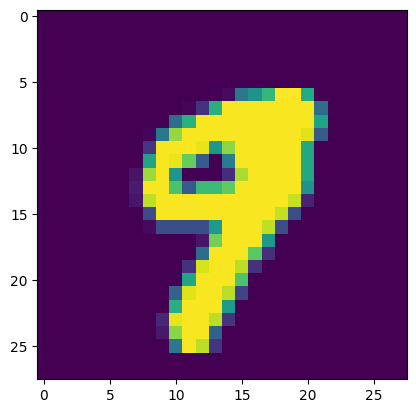

In [316]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(X_train)

In [317]:
from collections import defaultdict

POSITIVE_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def oh_encode(classes):
    NEG = -1.0
    POS = 1.0

    noise = np.array([NEG] * len(classes))

    oh_enc = defaultdict(lambda: noise)
    oh_dec = defaultdict(lambda: None)

    for i, cls in enumerate(classes):
        cls_vec = np.array([NEG] * len(classes))
        cls_vec[i] = POS
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    def oh_decoder(values):
        # pick the closest vector (is round() OK for that?)
        encoded = tuple(np.array([v.data for v in values]).round())
        return oh_dec[encoded]

    def oh_encoder(Y):
        return np.array([oh_enc[cls] for cls in Y])

    return oh_encoder, oh_decoder

OH_ENCODER, OH_DECODER = oh_encode(POSITIVE_CLASSES)

In [318]:
def get_batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]
    return X, Y_oh


def arr2vals(array, name=''):
    return [[Value(el, _name=name) for el in row] for row in array]


def batch2vals(batch):
    return tuple(map(arr2vals, batch))

In [319]:
def calc_accuracy(scores, ground_truths):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += OH_DECODER(score) == OH_DECODER(ground_truths)

    return matches / len(scores)


def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def calc_loss(scores, Y_oh):
    return sum(one_loss(xs, ys) for xs, ys in zip(scores, Y_oh))


def feed_forward(model, X):
    return list(map(model, X))


def evaluate(model, X_b, Y_b):
    input = arr2vals(X_b, 'input')
    scores = feed_forward(model, input)
    expected = arr2vals(Y_b, 'expected')
    return calc_loss(scores, expected), calc_accuracy(scores, expected)

# save/load

In [320]:
POSITIVE_NEURONS = 'mnist_parameters_10x785_positives.npy'


def save_neurons(file, neurons):
    weights = np.array([[p.data for p in n.parameters()] for n in neurons])
    np.save(file, weights)


def load_neurons(file):
    weights = np.load(file)
    neurons = [Neuron(nin=weights.shape[1] - 1, act='xspace') for _ in range(weights.shape[0])]
    for Wi in range(len(neurons)):
        for p, w in zip(neurons[Wi].parameters(), weights[Wi]):
            p.data = w
            p._lr = 0.0
    return neurons

In [321]:
def freeze_layers(model, lids: list):
    for idx in lids:
        for p in model.layers[idx].parameters():
            p._lr = 0.0


def norm_layers(model):
    for layer in model.layers:
        for neuron in layer.neurons:
            norm = sum(abs(p.data) for p in neuron.parameters())
            for p in neuron.parameters():
                p.data /= norm

In [322]:
Y_train_oh = OH_ENCODER(Y_train)
Y_train_oh.shape

(60000, 10)

In [323]:
# select positives
def select(X, Y, selector):
    idx = np.where(np.isin(Y, selector))[0]
    return X[idx], Y[idx]

def select_batch(X, Y, selector, batch_size):
    idx = np.where(np.isin(Y, selector))[0]
    return get_batch(X[idx], OH_ENCODER(Y[idx]), batch_size)

x, y_oh = select_batch(X_train, Y_train, [0, 1], 20)
x.shape, list(map(OH_DECODER, arr2vals(y_oh)))

((20, 784), [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [324]:
def fit(model, X, Y_oh, iterations, q=0.5, early_stop_at_loss=1e-9):
    total_loss, acc = evaluate(model, X, Y_oh)
    print(f"start: loss {total_loss.data}, accuracy {acc*100}%")

    for k in range(iterations):
        if total_loss.data == 0:
            print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")
            return total_loss.data, acc

        model.learn_from(total_loss, q)
        model.norm()

        total_loss, acc = evaluate(model, X, Y_oh)
        print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")

        if total_loss.data <= early_stop_at_loss:
            print(f"Early STOP!")
            break

    return total_loss.data, acc



def get_model_for(classes, batch_size, iterations, model=None):
    X, Y_oh = select_batch(X_train, Y_train, classes, batch_size)
    n = len(classes)

    # initialize a model
    if model is None:
        model = MLP(
            784,
            [
                (n * 2, 'xspace'),
                (10, 'xspace')
            ],
            lr=1.0
        )

    frozen_positives = [n for c, n in enumerate(load_neurons(POSITIVE_NEURONS)) if c in classes]
    model.layers[0].neurons = model.layers[0].neurons[:n] + frozen_positives

    total_loss, acc = fit(model, X, Y_oh, iterations)

    return model, total_loss, acc

In [325]:
BATCH_SIZE = 10
ITERATIONS = 10
SELECTED_CLASSES = [0, 1]

model, total_loss, accuracy = get_model_for(SELECTED_CLASSES, BATCH_SIZE, ITERATIONS)

start: loss 280.0, accuracy 0.0%
step 0: loss 40.0, accuracy 0.0%
step 1: loss 48.0, accuracy 40.0%
step 2: loss 48.0, accuracy 40.0%
step 3: loss 32.0, accuracy 60.0%
step 4: loss 40.0, accuracy 0.0%
step 5: loss 60.0, accuracy 10.0%
step 6: loss 24.0, accuracy 40.0%
step 7: loss 28.0, accuracy 30.0%
step 8: loss 48.0, accuracy 0.0%
step 9: loss 32.0, accuracy 30.0%


# DEBUG

In [334]:
model, total_loss, accuracy = get_model_for(SELECTED_CLASSES, BATCH_SIZE, ITERATIONS, model)

start: loss 36.0, accuracy 10.0%
step 0: loss 16.0, accuracy 80.0%
step 1: loss 56.0, accuracy 0.0%
step 2: loss 36.0, accuracy 10.0%
step 3: loss 64.0, accuracy 20.0%
step 4: loss 64.0, accuracy 20.0%
step 5: loss 32.0, accuracy 20.0%
step 6: loss 1.9721522630525295e-31, accuracy 100.0%
Early STOP!


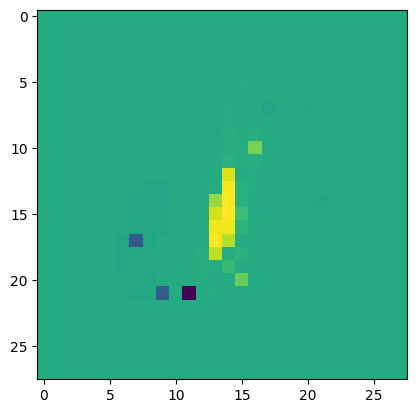

In [338]:
w = np.array([p.data for p in model.layers[0].neurons[1].parameters()][:-1])
w = w.reshape([-1, w.shape[0]])
draw_some(w)

In [343]:
import numpy as np

FROZEN_NEURONS = load_neurons(POSITIVE_NEURONS)

frozen_parameters # just set learning rate to 0.0

array([[-4.70093038e-04, -4.68479821e-04, -4.69502647e-04, ...,
        -4.69090211e-04, -4.68472566e-04,  4.68892510e-04],
       [-1.45667689e-01, -1.45118249e-01, -1.44764361e-01, ...,
        -1.45684912e-01, -1.44009873e-01,  1.44602413e-01],
       [-1.42613376e+01, -1.42600871e+01, -1.42599528e+01, ...,
        -1.42596654e+01, -1.42600232e+01,  1.42598849e+01],
       ...,
       [-6.92707308e-02, -6.87212902e-02, -6.83674023e-02, ...,
        -6.92879541e-02, -6.76129144e-02,  6.82054551e-02],
       [-2.55301041e-02, -2.49806636e-02, -2.46267757e-02, ...,
        -2.55473275e-02, -2.38722877e-02,  2.44648284e-02],
       [-4.16028373e+01, -4.16028366e+01, -4.16028362e+01, ...,
        -4.16028373e+01, -4.16028352e+01,  4.16028360e+01]])

In [73]:
# X_t, Y_t = get_batch(X_test, Y_t_oh, BATCH_SIZE)
X_t, Y_t = X_b, Y_b

input = arr2vals(X_t, 'input')
expected = arr2vals(Y_t, 'expected')
scores = feed_forward(model, input)

for a, e in zip(scores, expected):
    a, e = OH_DECODER(a), OH_DECODER(e)
    op = '=' if a == e else '!='
    print(f'actual: {a} {op} expected: {e}')

actual: 8 != expected: 6
actual: 8 = expected: 8


In [33]:
scores

[[Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [1.0, 0.0]),
  Value(auto : [-1.0, 0.0])],
 [Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [1.0, 0.0]),
  Value(auto : [-1.0, 0.0])]]

In [418]:
expected

[[Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [1.0, 0.0])]]

In [34]:
total_loss = loss(scores, expected)
total_loss.backward()
total_loss

Value(auto : [8.0, 1])

In [36]:
parameters = [p for p in model.layers[1].parameters() if p.grad > 0.0]
parameters.sort(key=lambda p: p._lr)
[p.data for p in parameters]

[0.09091930836562138,
 0.09090433245603816,
 0.0909059453985037,
 0.09091070230113207,
 0.09090884981203924,
 0.090902106311659,
 0.09090411950754398,
 0.09091737629039057,
 0.09091107035136436,
 0.09090774508449766,
 0.09090844412120991]